# The Effects of Randomness in training Neural Networks

### Author: Joel Eliason

This project is a joint project for both Optimization in Deep Learning and Deep Learning from Scratch. Therefore, the notebook submitted for the two projects is the same (this notebook).

## Introduction

In many scientific and commerical applications (including, of course, machine learning), we strive for high precision and accuracy. In fact, a common lay explanation of training neural networks is that, by tuning the weights of a nested composition of functions "just right", we are actually able to train a network to compute any function we desire (i.e. Turing completeness). However, many scientific studies have shown that inserting or building in randomness or lower precision into a neural network often results in comparable performance (and in a few cases, performance that exceeds that of its higher precision counterpart). This is apparent, actually, from the widespread use of stochastic gradient descent. This form of gradient descent operates by calculating the gradient of a small subset of samples (often called a batch or minibatch), instead of calculating the gradient on the whole sample set. The fundamental concept motivating this idea (and the ones we will examine below) is that adding noise to training sometimes allows the optimizer to "jump" out of shallower local minima in order to travel down steeper, more global minima. What's more, an examination of the effects of randomness in NN training is useful for environments in which lower precision is more of a necessity (for example, neuromorphic computation or embedded systems) or the hardware environment in which training is being performed is more susceptible to noise. Therefore, this project is motivated by the need to understand how generic neural networks will perform when being trained under more adversarial, noisy or memory-constrained conditions.

In particular, in this project, I will be performing 8 short experiments that subject neural network training to different forms of randomness.

In [1]:
%matplotlib inline

This project will utilize the PyTorch modeling language for all experiments. To run this code, you will need torch and torchvision installed.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.optim as optim

The following are utility functions. The first allows us to see the images in the data set, while the second one outputs a % accuracy of a trained network on a test set.

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
def accuracy(net):
    outputs = net(Variable(images1))
    _, predicted = torch.max(outputs.data, 1)
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

Since neuromorophic computation or embedded systems will most likely utilize smaller neural networks due to memory constraints, in this project I used a 6-layer ConvNet built in PyTorch (in fact, the net I use is a direct clone of the one used in the official tutorial on using PyTorch for deep learning). The 6 layers can be seen below. The first layer is a convolutional layer, in which each "neuron" acts as a trainable filter for the input data. Following that is a MaxPool layer, in which the max value in each 2x2 square of the input is taken as the output for that square. The last 3 layers are linear layers, which are fully-connected layers.

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The following function is my training function. This function takes a 'switch' argument that tells it which experiment to run. As can be seen, there are 8 different experiments that I will be running. Additionally, I will be training for 2 epochs per experiment (2 passes over the training data).

In [21]:
def train(switch):
    count_jump=0
    if switch=='bias':
        biases=[];
        for p in net.parameters():
            biases.append(torch.from_numpy(np.random.uniform(-scale,scale,size=p.data.size())).float())
    elif switch=='binarizeweights':
        clips=[]
        for p in net.parameters():
            clips.append(f*np.std(p.data.numpy()))
    for epoch in range(2):  # loop over the dataset twice
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            if switch=='none':
                loss.backward()
            elif switch=='rgrad':
                loss.backward(scale*torch.randn(1,1))
            elif switch=='addnoise':
                loss.backward()
                for p in net.parameters():
                    p.grad.data.add_(torch.from_numpy(np.random.normal(0,variance,size=p.data.shape)).float())
            elif switch=='mulnoise':
                loss.backward()
                for p in net.parameters():
                    p.grad.data.mul_(torch.from_numpy(np.random.normal(1,variance,size=p.data.shape)).float())
            elif switch=='bias':
                loss.backward()
                count=0
                for p in net.parameters():
                    p.data.add_(biases[count])
                    count+=1
            elif switch=='jump':
                to_jump=np.random.choice([True, False], size=(1,), p=[1./frequency, np.true_divide((frequency-1),frequency)])
                loss.backward()
                if to_jump:
                    count_jump+=1
                    print "Jump here"
                    for p in net.parameters():
                        p.data.add_(torch.from_numpy(np.random.normal(0,variance,size=p.data.shape)).float())
            elif switch=='randomizeweights':
                for p in net.parameters():
                    bools=np.random.choice([1,0],size=p.data.shape,p=[1./frequency, np.true_divide((frequency-1),frequency)])
                    bools=torch.from_numpy(bools)
                    p.data[bools==1]=0
                    rands=torch.from_numpy(np.random.normal(0,variance,size=p.data.shape)).float()
                    rands[bools==0]=0
                    p.data.add_(rands)
                loss.backward()
            elif switch=='binarizeweights':
                max_weights=[]
                weight_holder=[]
                count=0
                for p in net.parameters():
                    max_weights.append(float(np.max(p.data.numpy())))
                    weight_holder.append(p.data.clone())
                    p.data[p.data<0]=-max_weights[count]
                    p.data[p.data>0]=max_weights[count]
                    count+=1
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                count=0
                for p in net.parameters():
                    p.data=weight_holder[count]
                    p.data.clamp(-clips[count],clips[count])
                    count+=1
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    if switch=='jump':
        print "Number of jumps = "+str(count_jump)
    elif switch=='binarizeweights':
        for p in net.parameters():
            p.data[p.data<0]=-1
            p.data[p.data>0]=1

#### Data loading

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Here's some of the images that our network will be seeing during training:

  dog truck   dog  frog


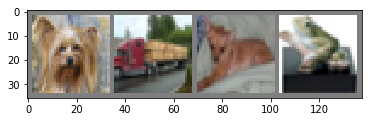

In [9]:
# get some random training images
dataiter = iter(trainloader)
images1, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Experiments

#### 1. No stochasticity

In this first experiment, we establish a baseline: here, we have done training without any weight or gradient distortions or perturbations. As we can see, for being such a small ConvNet and for only training for 2 epochs, we get quite good performance.

In [10]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
train('none')

[1,  2000] loss: 2.161
[1,  4000] loss: 1.818
[1,  6000] loss: 1.655
[1,  8000] loss: 1.558
[1, 10000] loss: 1.512
[1, 12000] loss: 1.453
[2,  2000] loss: 1.389
[2,  4000] loss: 1.353
[2,  6000] loss: 1.357
[2,  8000] loss: 1.320
[2, 10000] loss: 1.301
[2, 12000] loss: 1.272
Finished Training


In [12]:
accuracy(net)

Accuracy of the network on the 10000 test images: 55 %


#### 2. Random gradients

In this experiment, I test the hypothesis that we don't need to retain any information about the cost function at all when starting backpropagation (this hypothesis is, of course, ludicrous, since without cost function gradient information, we are just doing a random walk around the cost function). Nevertheless, this helps us establish a baseline of "maximum randomness" to compare against in further experiments.

In [99]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scale=0.2

In [24]:
train('rgrad')

[1,  2000] loss: 2.307
[1,  4000] loss: 2.304
[1,  6000] loss: 2.306
[1,  8000] loss: 2.305
[1, 10000] loss: 2.305
[1, 12000] loss: 2.304
[2,  2000] loss: 2.307
[2,  4000] loss: 2.307
[2,  6000] loss: 2.306
[2,  8000] loss: 2.306
[2, 10000] loss: 2.308
[2, 12000] loss: 2.307
Finished Training


In [25]:
accuracy(net)

Accuracy of the network on the 10000 test images: 10 %


### Additive and multiplicative noise

#### 3. Adding white noise to the gradient

In this experiment, I implement a common practice in training neural networks: that of adding noise during training to improve training. The intuition behind this is the same as in stochastic gradient descent: a little bit of randomness can allow us to escape shallower local minima, in favor of (hopefully) deeper minima.  In this particular implementation, I add noise to the gradients (rather than the weights themselves). This experiment was inspired by Ref. [1], which implements the noise according to a particular schedule. Here, however, I simply add a small bit of normally-distributed noise to the gradient of the cost wrt every weight during each minibatch. As it turns out, with a network this small and low numbers of epochs, the impact of noise is very slight (in fact, in this case has no impact on the classification error). Additionally, the variance of this noise is another knob to tune here: too high of variance leads to divergence in the cost function, while too low will have no impact on training at all. During my experiments, I could not find a noise variance that had a significantly positive impact on training, which matches my intuition. However, variance that yields even quite large (relatively speaking) noise signals does not have that detrimental of an impact (see below: variance = 0.1 yields a 47% accuracy, not much lower than the totally noise-free training above).

In [19]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
variance=0.1

In [20]:
train('addnoise')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.831
[1,  6000] loss: 1.716
[1,  8000] loss: 1.633
[1, 10000] loss: 1.586
[1, 12000] loss: 1.567
[2,  2000] loss: 1.535
[2,  4000] loss: 1.510
[2,  6000] loss: 1.501
[2,  8000] loss: 1.504
[2, 10000] loss: 1.493
[2, 12000] loss: 1.495
Finished Training


In [21]:
accuracy(net)

Accuracy of the network on the 10000 test images: 47 %


#### 4. Multiplying the gradient by white noise

This experiment is a slightly different tack on the previous one. Here, instead of adding noise to the gradients, I multiply each gradient during each minibatch by a small bit of normally distributed noise (with mean 1). This is, in theory, very similar to adding noise to the gradients. However, here we can use a much larger variance than in the additive noise case (try it! set both additive and multiplicative variance to 0.1). It's not intuitively clear to me why this should be the case, so further experiments could be designed to probe this case further. Again, in this experiment, the variance is the knob to tune. 

In [40]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
variance=0.1

In [35]:
train('mulnoise')

[1,  2000] loss: 2.196
[1,  4000] loss: 1.894
[1,  6000] loss: 1.707
[1,  8000] loss: 1.592
[1, 10000] loss: 1.551
[1, 12000] loss: 1.478
[2,  2000] loss: 1.432
[2,  4000] loss: 1.420
[2,  6000] loss: 1.398
[2,  8000] loss: 1.387
[2, 10000] loss: 1.365
[2, 12000] loss: 1.357
Finished Training


In [36]:
accuracy(net)

Accuracy of the network on the 10000 test images: 52 %


### Perturbing weights

#### 5. Constant bias added to weights after every backward pass

This experiment was a failed attempt at feedback alignment (Ref.[2]), in which error information is backpropagated along random channels (instead of along the channels that connect each neuron in each layer). However, tthe time cost with which I was having to break down the PyTorch code to implement this was becoming prohibitive, so I simply ended up adding a constant bias to each weight after every backward pass. This experiment has no theoretical basis for actually working, since adding a constant (uniformly distributed) bias will always steer the weights along the cost function in a counterproductive direction, unless that bias happens to be in the direction of steepest descent (which is exponentially unlikely in such a high-dimensional space). The knob to tune here is the magnitude of the bias (the scale parameter below). Gradient descent is unable to compensate for a bias that is larger than the learning rate - thus, the key to compensating for such a bias is to have an adaptive learning rate, in which the network "realizes" that it is being biased in a counterproductive direction and then compensates by updating the learning rate to be larger than the magnitude of the bias.

In [22]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scale=0.001

In [23]:
train('bias')

[1,  2000] loss: 11.647
[1,  4000] loss: nan
[1,  6000] loss: nan
[1,  8000] loss: nan
[1, 10000] loss: nan
[1, 12000] loss: nan
[2,  2000] loss: nan
[2,  4000] loss: nan
[2,  6000] loss: nan
[2,  8000] loss: nan
[2, 10000] loss: nan
[2, 12000] loss: nan
Finished Training


In [24]:
accuracy(net)

Accuracy of the network on the 10000 test images: 10 %


#### 6. Stochastic jump to new area of cost function

There are many minima that are approximately equally as good as one another in the high-dimensional cost function space. This experiment was designed to explore the cost function space more thoroughly: at random times, a random jump is administed to all the weights in the net, "jumping" it to a completely different area of the cost function that would have otherwise been unexplored. The frequency of jumps is the varying parameter here. If there are too many jumps, the cost function doesn't get too far beyond taking a few optimizing steps before jumping to a new location. Here, jump times are assigned randomly - however, one could imagine a better version of this "cost function exploration" idea as deciding to jump when the magnitude of the gradient drops below a certain threshold (indicating a shallowing out of the cost function), but the cost function itself is still above a different threshold. This would, in essence, allow the net to escape saddle points, which often trap optimizers. Additionally, I tried increasing the learning rate, so that optimization could proceed more quickly once a jump had been made. However,  I was not able to show that this had a positive impact, for any frequency. All in all, stochastic jumping, as implemented here, reduced neural network training to "maximum randomness". When testing, this frequency should not be much greater than about 20000 (otherwise jumps never occur).

In [39]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # could try increasing the learning rate in this experiment
frequency=20000 # this is actually inverse of frequency, so the higher the frequency, the less jumps
variance = 1 # if variance = 0.1, training does not get totally upended (since weights don't move as far) as it does with variance = 1

In [40]:
train('jump')

[1,  2000] loss: 2.160
[1,  4000] loss: 1.848
[1,  6000] loss: 1.717
[1,  8000] loss: 1.586
[1, 10000] loss: 1.524
Jump here
[1, 12000] loss: nan
[2,  2000] loss: nan
[2,  4000] loss: nan
[2,  6000] loss: nan
[2,  8000] loss: nan
[2, 10000] loss: nan
[2, 12000] loss: nan
Finished Training
Number of jumps = 1


In [41]:
accuracy(net)

Accuracy of the network on the 10000 test images: 10 %


#### 7. Binarize weights

This concept was the most interesting one that I examined. In this experiment, I restricted the values of the weights and activations on the forward and backward pass to be 1 and -1. Such a weight projection is called "low-precision", since these weights only require 1 bit of precision to be stored. Such low demands on memory are highly desirable for embedded systems and neuromorphic computing, which are often strapped for memory and power consumption. At least a few papers have shown that binary neural networks (BNNs) perform similarly to higher precision neural networks (Refs. [3], [4]). In my experiment, I was not able to achieve any sort of good performance, even after implementing the exact algorithm from these references. My opinion on this is that my ConvNet is much smaller than in those references, and thus may not be able to encode very complex representations using only binary weights. Of course, further experimentation with various architectures would be needed to really flesh out the utility of binarization for small neural nets.

In [40]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
f=0.5 # scales the clipping parameter, should be left at f = 0.5

In [23]:
train('binarizeweights')

[1,  2000] loss: 2.274
[1,  4000] loss: 2.311
[1,  6000] loss: 2.314
[1,  8000] loss: 2.312
[1, 10000] loss: 2.311
[1, 12000] loss: 2.311
[2,  2000] loss: 2.312
[2,  4000] loss: 2.314
[2,  6000] loss: 2.311
[2,  8000] loss: 2.312
[2, 10000] loss: 2.311
[2, 12000] loss: 2.312
Finished Training


In [24]:
accuracy(net)

Accuracy of the network on the 10000 test images: 10 %


#### 8. Randomize weights

In this last experiment, I devised a concept somewhat reminiscent of the regularization technique of Dropout. Dropout is a method to induce robustness and encourage finding global minima, in which subsets of weights are "frozen" (i.e. not used in training) on particular minibatches. In contrast, my technique, instead of freezing the weights, simply reassigns them to normally-distributed numbers. This is a similar technique to the stochastic jump experiment examined above, in which all the weights are randomly perturbed. This technique differs in that only a very small subset of the weights are reassigned during each minibatch. Again, the "frequency" and variance of the randomly reassigned number are the knobs to tune in this example. In running this experiment, changing the variance below 0.1 did not have an effect on training while the frequency was at or above 100000. For frequencies less than this, weight randomization was influenced by both variance and frequency - a lower "frequency" requires a lower variance of noise in order to still train effectively.

In [37]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
frequency=10000 # this is actually inverse of frequency, so the higher the frequency, the less random weight switching
variance=0.1 # don't change it above 0.5 - will cause divergence in training

In [38]:
train('randomizeweights')

[1,  2000] loss: 2.224
[1,  4000] loss: 1.856
[1,  6000] loss: 1.722
[1,  8000] loss: 1.651
[1, 10000] loss: 1.630
[1, 12000] loss: 1.606
[2,  2000] loss: 1.577
[2,  4000] loss: 1.583
[2,  6000] loss: 1.552
[2,  8000] loss: 1.566
[2, 10000] loss: 1.563
[2, 12000] loss: 1.534
Finished Training


In [39]:
accuracy(net)

Accuracy of the network on the 10000 test images: 44 %


### Conclusion

This project focused on the effects of random perturbations to weights or gradients during training of neural networks. In particular, I used the heuristic of injecting randomness to the training process to encourage the escaping of "shallow minima". Many of the above experiments showed similar results: for example, randomization of the weights, additive noise and multiplicative noise all did not significantly alter the training process, as long as the noise variances or the application of the noisiness (as in weight randomization) were not too high. In some of these experiments (stochastic jumping and weight randomization), two parameters were present. Performing analyses of training in two parameters takes much more time, since there are more combinations of parameters to test and sometimes subtle interactions between parameters. Therefore, due to time constraints, I was not able to flesh out more precise relationships between the parameters and training in these two experiments.

In this project, I focused on the effects of randomness in training neural networks. In particular, I focused on these effects for small neural networks with low training times. Noise did not have a significant positive impact in my experiments, as it has in previous works. However, if noise was small, the lower precision induced by noise did not significantly impact the training of small neural networks.

Further work in this direction would include examining more closely the difference between multiplicative noise and additive noise, and in particular, why one seems to have a more significant impact than the other. In addition, I would like to further investigate weight binarization in small neural networks, whether or not it is possible in small nets, and to what degree. Lastly, it will be important to get sharper bounds on allowable noise in small neural net training, as understanding the precise relationship between noise and neural network training will be paramount in neuromorphic computing and embedded systems.

### References

[1] Arvind Neelakantan, Luke Vilnis, Quoc V. Le, Ilya Sutskever, Lukasz Kaiser, Karol Kurach: “Adding Gradient Noise Improves Learning for Very Deep Networks”, 2015; arXiv:1511.06807.

[2] Timothy P. Lillicrap, Daniel Cownden, Douglas B. Tweed: “Random feedback weights support learning in deep neural networks”, 2014; arXiv:1411.0247.

[3] Matthieu Courbariaux, Itay Hubara, Daniel Soudry, Ran El-Yaniv: “Binarized Neural Networks: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1”, 2016; arXiv:1602.02830.

[4] Paul Merolla, Rathinakumar Appuswamy, John Arthur, Steve K. Esser: “Deep neural networks are robust to weight binarization and other non-linear distortions”, 2016; arXiv:1606.01981.